In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

from microfit import run_plotter as rp
from microfit import histogram as hist

from microfit import variable_definitions as vdef
from microfit import selections

In [3]:
RUN = ["3"] #important that it's a string 1) new format to include latest runs 2) to include 'mc_pdg' otherwise it gets dropped

rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    loadpi0variables=False,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
#    load_lee=True,
    blinded=True,
    enable_cache=True,
)

# Calculating the proton momentum component variables, where i=x,y,z

def calculate_trk_pi(row, vec_name):
    """Function to calculate the proton momentum component variables, where i=x,y,z.
        Parameters:
        -----------
        vec_name : str
            The direction variable. Can be either 'trk_dir_x_v', 'trk_dir_y_v' or 'trk_dir_z_v'.

        Returns:
        --------
        trk_pi : float
            The momentum component of the specified direction.
    """
    trk_id = row['trk_id'] -1
    trk_vec = row[vec_name]
    trk_p = row['mod_trk_p']
    
    # Access the 'trk_id'-th element of the 'trk_vec' vector and multiply it by 'trk_p'
    # But first check if trk_id is within the valid range of 'trk_vec'
    if 0 <= trk_id < len(trk_vec):
        trk_pi = trk_p * trk_vec[trk_id]
    else:
        trk_pi = np.nan  # Set to NaN for out-of-bounds indices
    
    return trk_pi

def calculate_pt(row, particle):
    """Function to calculate the transverse projection vector of the electron and proton momenta. 
        This will be used in calculating the TKI variable delta_pt.
        Parameters:
        -----------
        particle : str
            The particle for which the transverse momentum needs to be calculated. Can be either 'electron' or 'proton'.

        Returns:
        --------
        pt: numpy array of floats
            The transverse projection of the particle momentum.
    """
    
    if particle == 'electron':
        px = row['shr_px']
        py = row['shr_py']
        
    elif particle == 'proton':
        px = row['trk_px']
        py = row['trk_py']
        
    pt = np.array([px, py])
    return pt

def calculate_delta_alpha(row):
    """Function to calculate the TKI variable delta_alpha."""
    return np.degrees(np.arccos(np.inner(-1 * row['shr_pt'], row['delta_pt']) / (np.linalg.norm(row['shr_pt']) * row['mod_delta_pt'])))


for key, df in rundata.items():
    if key!='data':
        
        # Calculating the modulus of the proton momentum using trk_energy as the kinetic energy
        m_p = 0.938 # GeV (natural units c=1)
        gamma = (df['trk_energy'] / m_p) + 1
        beta = np.sqrt(1 - (1/gamma**2))
        df['mod_trk_p'] = m_p * gamma * beta # c=1

        df['trk_px'] = df.apply(calculate_trk_pi, axis=1, vec_name='trk_dir_x_v')
        df['trk_py'] = df.apply(calculate_trk_pi, axis=1, vec_name='trk_dir_y_v')
        df['trk_pz'] = df.apply(calculate_trk_pi, axis=1, vec_name='trk_dir_z_v')
        
        # Making corrections to the electron energy and momentum variables
        
        df['shr_px'] = df['shr_px'] * df['shr_energy_cali'] / df['shr_energy'] / 0.83
        df['shr_py'] = df['shr_py'] * df['shr_energy_cali'] / df['shr_energy'] / 0.83
        df['shr_pz'] = df['shr_pz'] * df['shr_energy_cali'] / df['shr_energy'] / 0.83
        
        df['shr_energy_cali'] = df['shr_energy_cali'] * 1/0.83
        
        # Calculating the modulus of the electron momentum
        df['mod_shr_p'] = np.sqrt((df['shr_px'])**2 + (df['shr_py'])**2 + (df['shr_pz'])**2)
        
        # Calculating the transverse momentum projection of the electron and proton
        df['shr_pt'] = df.apply(calculate_pt, axis=1, particle='electron')
        df['trk_pt'] = df.apply(calculate_pt, axis=1, particle='proton')
        
        # Calculating TKI delta_pt
        df['delta_pt'] = df['shr_pt'] + df['trk_pt']
        df['mod_delta_pt'] = df['delta_pt'].apply(lambda vec: np.linalg.norm(vec))
        
        # Calculating TKI delta_alpha
        df['delta_alpha'] = df.apply(calculate_delta_alpha, axis=1)

In [4]:
print(rundata.keys())
print("mod_shr_p" in rundata["mc"].columns)

dict_keys(['data', 'ext', 'mc', 'nue', 'drt'])
True


In [ ]:
import uproot

fold = "nuselection"
tree = "NeutrinoSelectionFilter"
path = "/uboone/data/users/cthorpe/PELEE_2023_Samples/"
RUN1 = "run1/nuepresel/"
RUN2 = "run2/nuepresel/"
RUN3 = "run3/nuepresel/"
RUN4 = "run4/nuepresel/"
RUN5 = "run5/nuepresel/"
fn = "overlay_peleeTuple_uboone_v08_00_00_70_run3_nu.root"

data_path = path + RUN3 + fn

df = uproot.open('/pnfs/uboone/persistent/users/jdetje/pelee_v08_00_00_70/overlay_peleeTuple_uboone_v08_00_00_70_run3_nu.root')[fold][tree].pandas.df(flatten=False)
print('pi0_nshower' in df.columns)

In [ ]:
plt.hist(df['pi0truth_gamma1_edep'], 50)

In [15]:
RUN = ["3"]

rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    loadpi0variables=False,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
#    load_lee=True,
    blinded=True,
    enable_cache=True,
)
print('mc_pdg' in rundata["mc"].columns)

> /uboone/app/users/mmoudgal/pelee/PELEE/data_loading.py(2281)load_runs()
   2279     )  # same format as load_run weights dictionary but with the weights combined for each dataset by run
   2280     import pdb; pdb.set_trace()
-> 2281     for run in run_numbers:
   2282         runsdata[f"{run}"], weights[f"{run}"], data_pots[run_numbers.index(run)] = _load_run(run, **load_run_kwargs)
   2283     pot_sum = np.sum(data_pots)

ipdb> c


/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['mc_pz', 'mc_py', 'trk_len_v', 'trk_dir_y_v', 'mc_pdg',
       'pfp_generation_v', 'trk_dir_x_v', 'mc_px', 'trk_llr_pid_score_v',
       'trk_dir_z_v', 'mc_E'],
      dtype='object')]

  encoding=encoding,
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['mc_pz', 'mc_py', 'trk_len_v', 'trk_dir_y_v', 'mc_pdg',
       'pfp_generation_v', 'trk_dir_x_v', 'weightsGenie', 'mc_px',
       'trk_llr_pid_score_v', 'weightsFlux', 'weightsReint', 'trk_dir_z_v',
       'mc_

True


In [3]:
run3mc = dl.load_sample(
    "3",
    dataset="mc",
    category="runs",
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True
    )

../../data_loading.py:766: RuntimeWarning: invalid value encountered in true_divide
  df["proton_pz"] = np.where((mc_E_prot > 0), mc_pz_prot / mc_p_prot, np.nan)
../../data_loading.py:603: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
../../data_loading.py:603: RuntimeWarning: overflow encountered in float_scalars
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
run3 = dl._load_run(
    "3",
    data="bnb",
    loadpi0variables=False,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True
)

In [6]:
rundata3, mc_weights3, data_pot3 = dl.load_runs(
    "3",
    data="bnb",
    loadpi0variables=False,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True
)


> /uboone/app/users/mmoudgal/pelee/PELEE/data_loading.py(2281)load_runs()
   2279     )  # same format as load_run weights dictionary but with the weights combined for each dataset by run
   2280     import pdb; pdb.set_trace()
-> 2281     for run in run_numbers:
   2282         runsdata[f"{run}"], weights[f"{run}"], data_pots[run_numbers.index(run)] = _load_run(run, **load_run_kwargs)
   2283     pot_sum = np.sum(data_pots)

ipdb> c


../../data_loading.py:759: RuntimeWarning: invalid value encountered in true_divide
  df["proton_pz"] = np.where((mc_E_prot > 0), mc_pz_prot / mc_p_prot, np.nan)


In [11]:
print('mc_pdg' in rundata3["drt"].columns)
print(rundata3.keys())
rundata3["mc"].loc[:, 'mc_pdg'].head()

True
dict_keys(['data', 'ext', 'mc', 'nue', 'drt'])


entry
0    [13, 2212, 2112, 2212, 321, 2212, 2112, -321]
1    [14, 2112, 2212, 2212, 2212, 2212, 2212, 111]
2                       [14, 2112, 211, 211, -211]
3                                  [14, 2112, 111]
4                [14, 2112, 2212, 2212, -211, 111]
Name: mc_pdg, dtype: object

In [ ]:
prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2

In [10]:
run3mc.head()

entry
0    [13, 2212, 2112, 2212, 321, 2212, 2112, -321]
1    [14, 2112, 2212, 2212, 2212, 2212, 2212, 111]
2                       [14, 2112, 211, 211, -211]
3                                  [14, 2112, 111]
4                [14, 2112, 2212, 2212, -211, 111]
Name: mc_pdg, dtype: object

In [5]:
print(rundata.keys())

dict_keys(['data', 'ext', 'mc', 'nue', 'drt'])


In [5]:
from microfit import selections as sel

selection = "OnePL"
preselection = "OneP"
query = f"{sel.preselection_categories[preselection]['query']} and {sel.selection_categories[selection]['query']}"
#print(query)

all_mc = pd.concat([df for k, df in rundata.items() if k!='data' or k!='ext'])
all_predict = all_mc.query(query, engine='python')

df2 = all_predict[all_predict['pfp_generation_v'].apply(lambda x: all(elem == 2 for elem in x))]
print(len(all_predict))
print(len(df2))
df2.loc[:, ['dataset', 'pfp_generation_v']].head(20)

In [6]:
all_predict.loc[:, 'mc_pdg'].head()

KeyError: 'mc_pdg'

In [4]:
all_predict = pd.concat([df for k, df in rundata.items() if k!='data'])
all_predict.loc[:, ['trk_energy', 'trk_id', 'mod_trk_p', 'trk_dir_x_v', 'trk_px','trk_dir_y_v', 'trk_py','trk_dir_z_v','trk_pz']].head(20)

,trk_energy,trk_id,mod_trk_p,trk_dir_x_v,trk_px,trk_dir_y_v,trk_py,trk_dir_z_v,trk_pz
entry,,,,,,,,,
0,0.000000,0,0.000000,[0.47086182],NaN,[0.8216522],NaN,[0.32121173],NaN
1,0.158715,2,0.568278,"[-0.29305825, -0.07713298, 0.5054329, -0.04046...",-0.043833,"[0.95549864, 0.99698377, -0.7406513, 0.2660279]",0.566564,"[0.033752203, -0.008605935, 0.44268864, 0.9631...",-0.004891
2,0.680067,1,1.318445,"[-0.21607879, -0.09295654, 0.19567071, 0.38058...",-0.284888,"[0.8527872, 0.9956281, -0.87326646, 0.8747957]",1.124353,"[0.47546184, -0.009155273, -0.44622716, 0.2998...",0.626870
3,0.000000,0,0.000000,"[-0.37325746, -0.20408146]",NaN,"[-0.5028064, -0.2490099]",NaN,"[0.77965677, 0.9467549]",NaN
4,0.039126,4,0.273737,"[0.3062771, 0.11935401, -0.77638704, 0.7071299]",0.193568,"[-0.8826664, -0.62572306, 0.17135137, -0.4155581]",-0.113754,"[-0.35650283, 0.77086014, -0.60651624, 0.5720829]",0.156600
5,0.000000,0,0.000000,[-0.44385576],NaN,[0.8343391],NaN,[0.32691026],NaN
6,0.116609,1,0.482033,"[0.4558788, 0.28459296, -0.08758652, -0.138338...",0.219748,"[0.7450221, 0.9252285, -0.49041587, 0.2688405,...",0.359125,"[0.48694617, 0.25091666, 0.8670761, -0.9531985...",0.234724
7,0.408838,2,0.966503,"[0.5405732, 0.5582728, -0.33546454, 0.09189585]",0.539572,"[0.832512, 0.75635266, 0.72903454, -0.44100088]",0.731017,"[-0.12126161, 0.34097257, 0.59663403, 0.8927897]",0.329551
8,0.025314,2,0.219387,"[0.86902124, -0.3038644]",-0.066664,"[0.4905749, -0.054161225]",-0.011882,"[0.06433069, 0.95117456]",0.208675


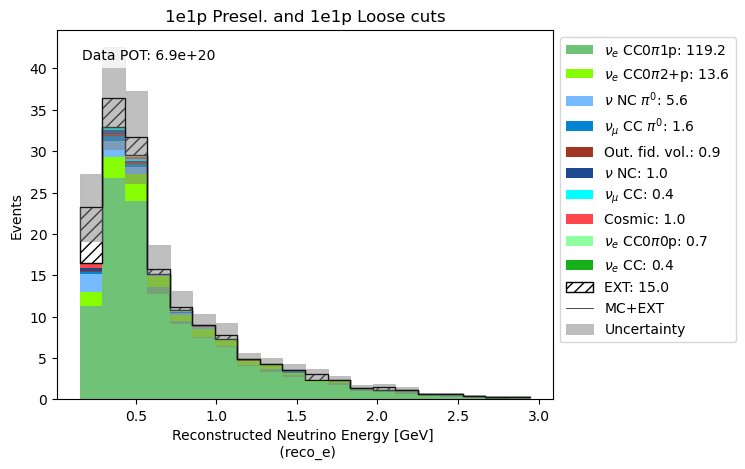

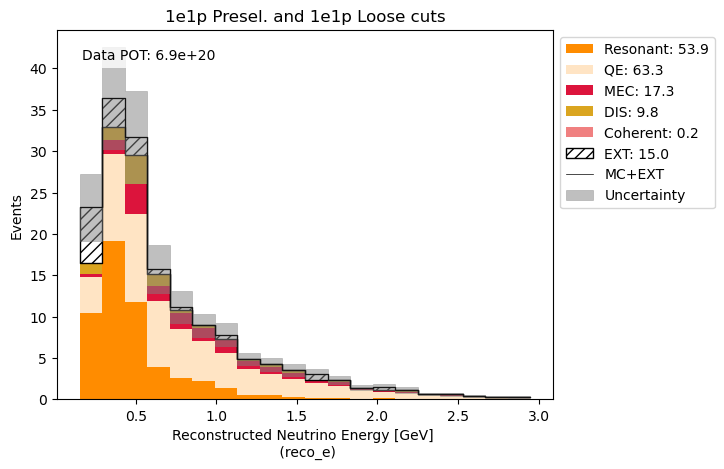

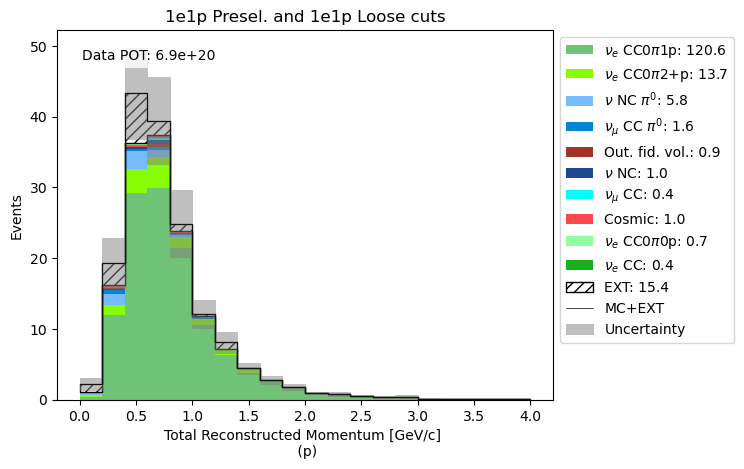

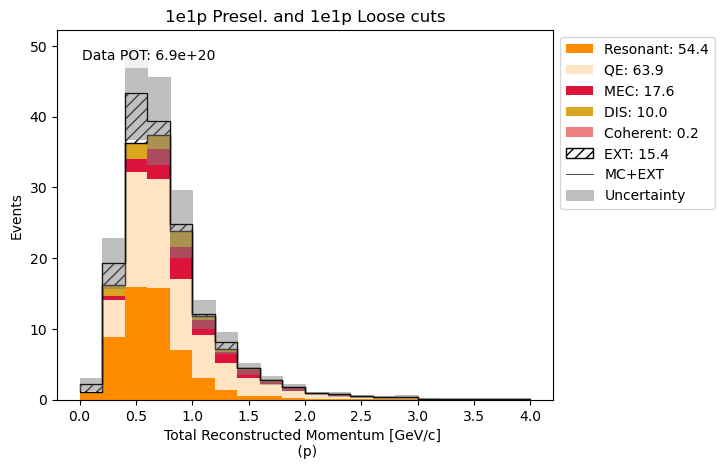

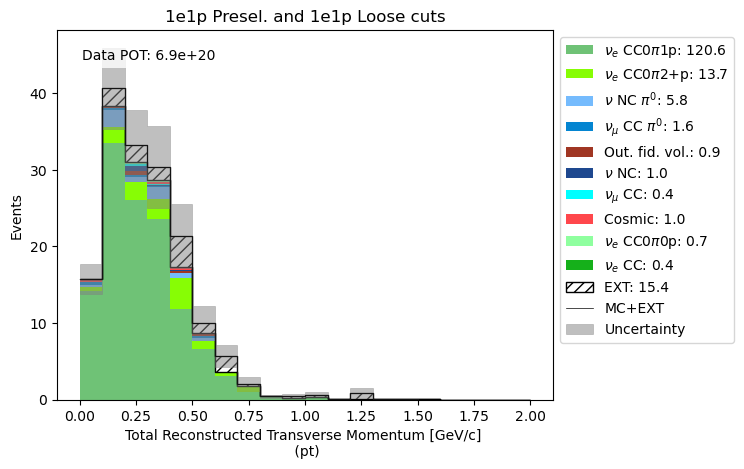

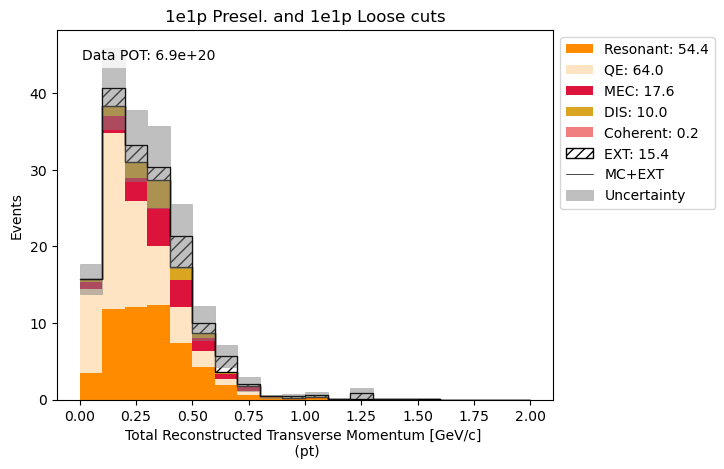

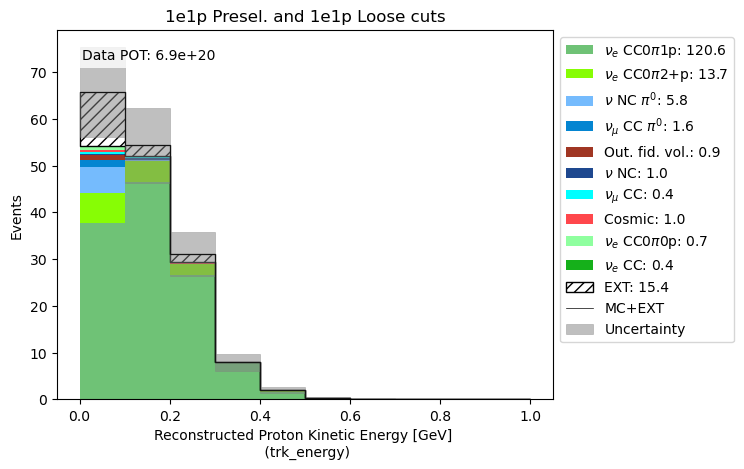

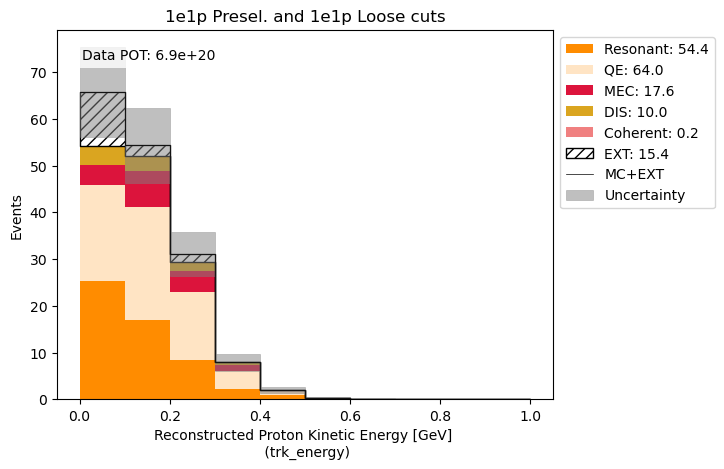

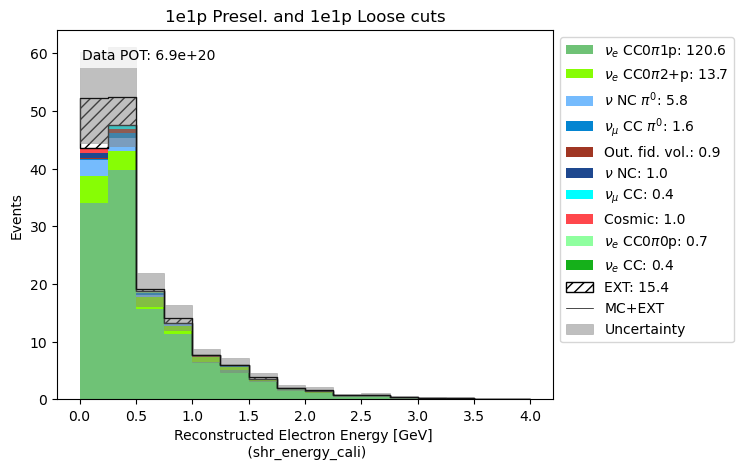

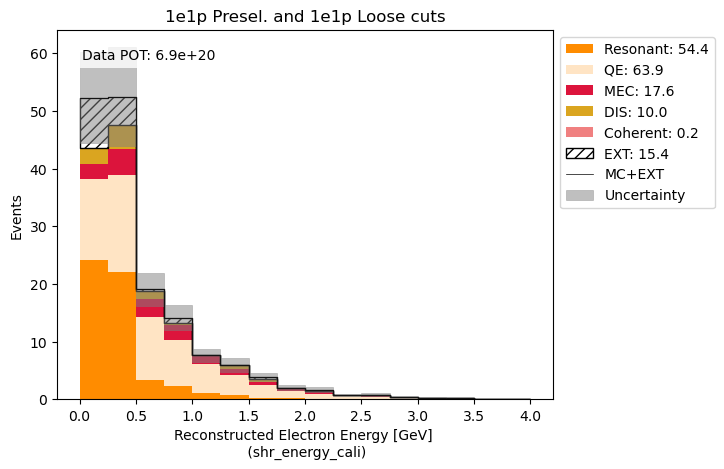

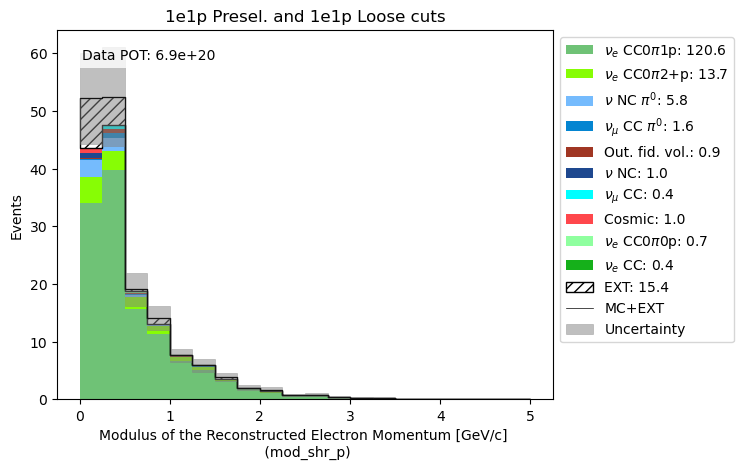

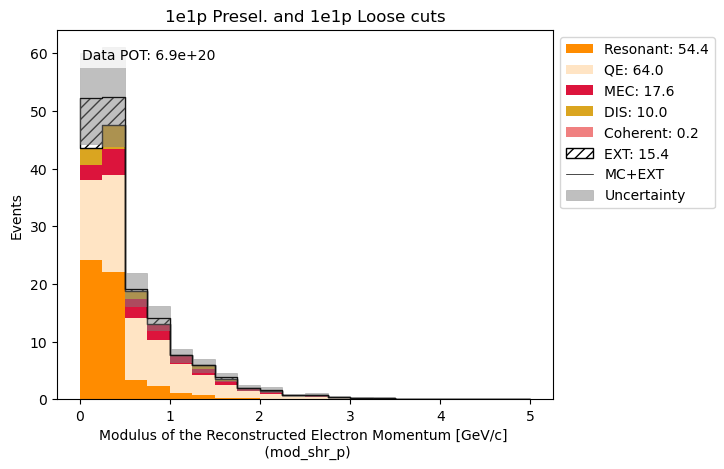

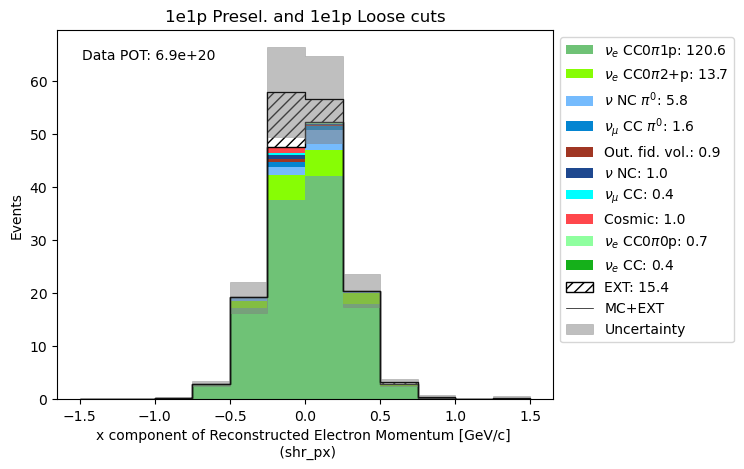

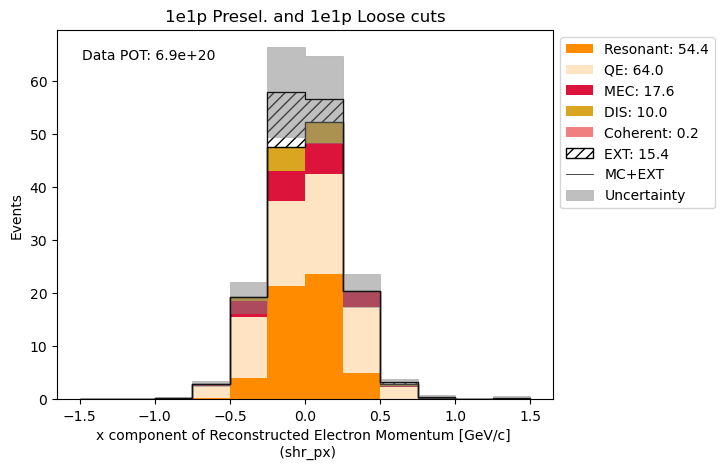

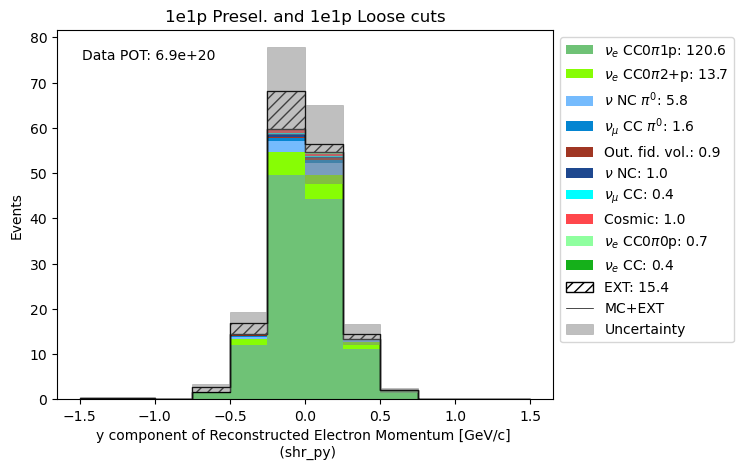

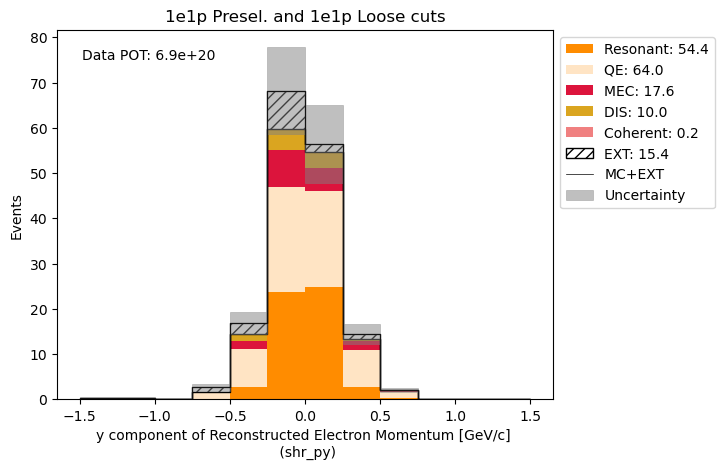

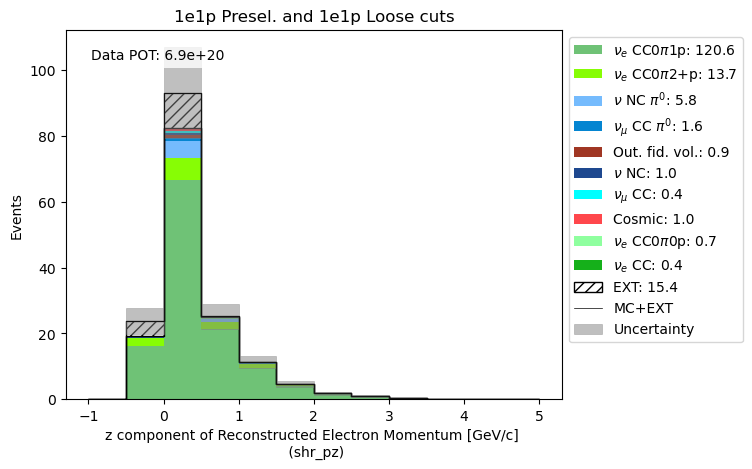

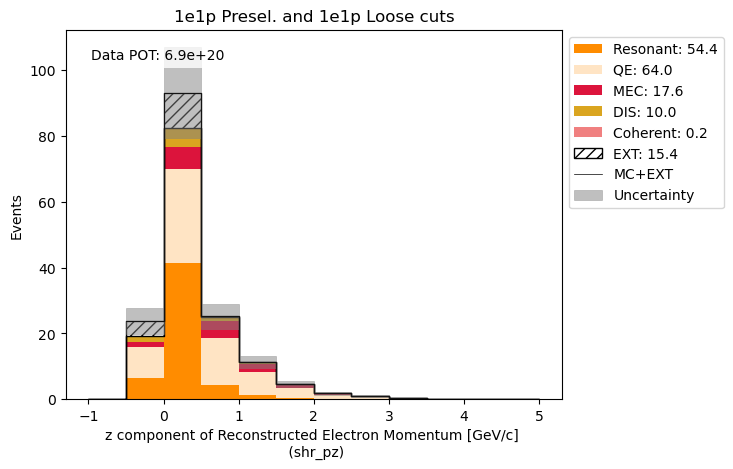

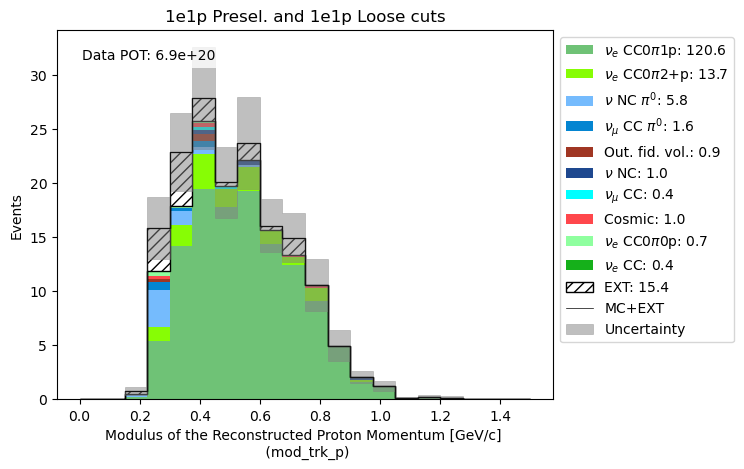

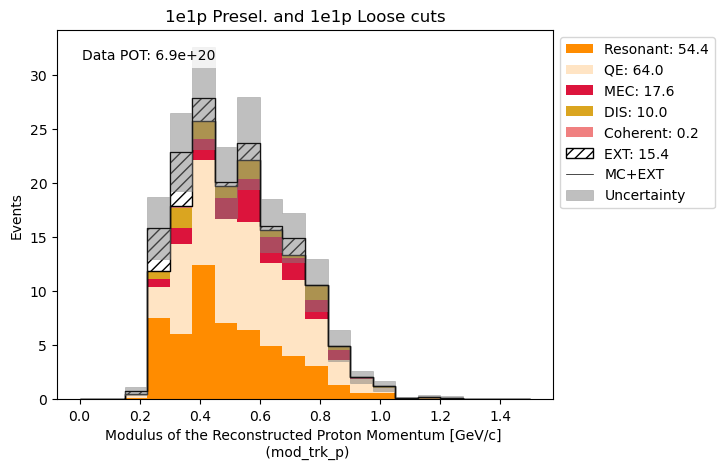

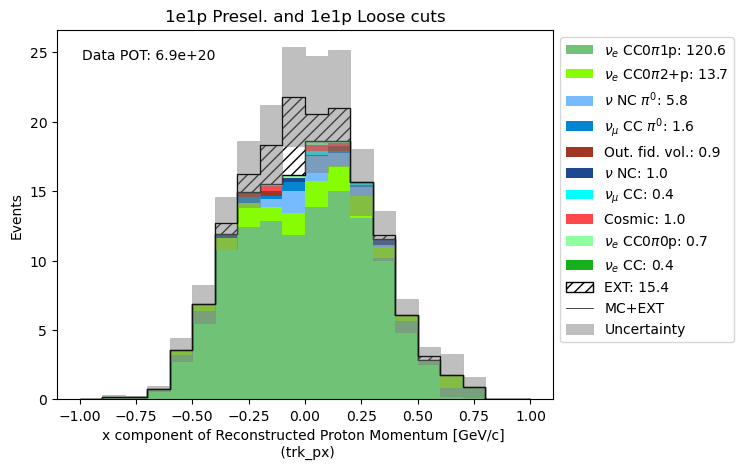

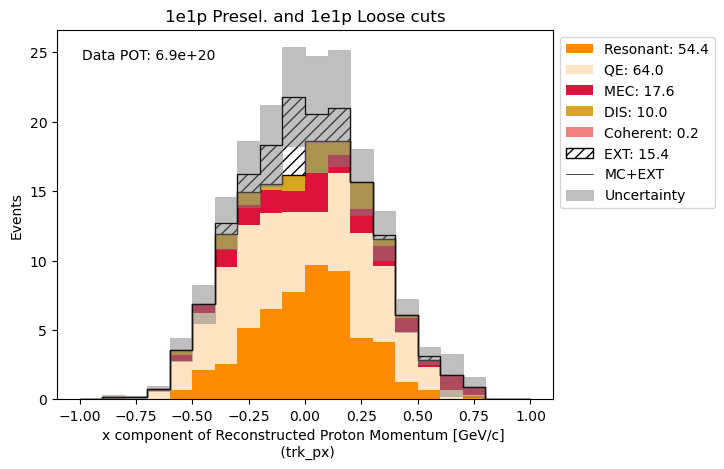

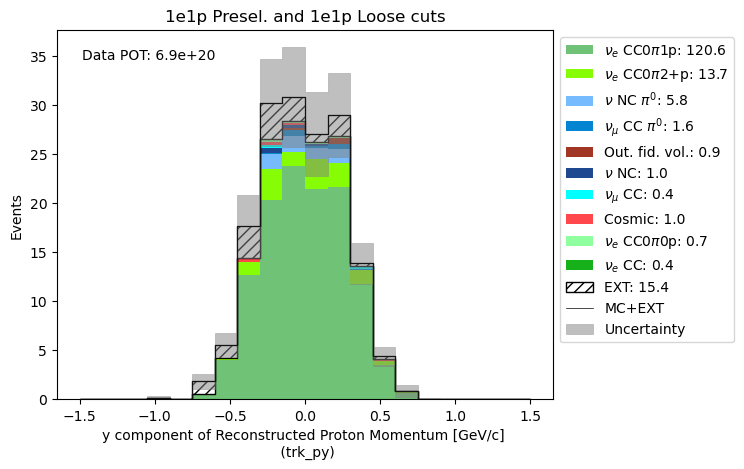

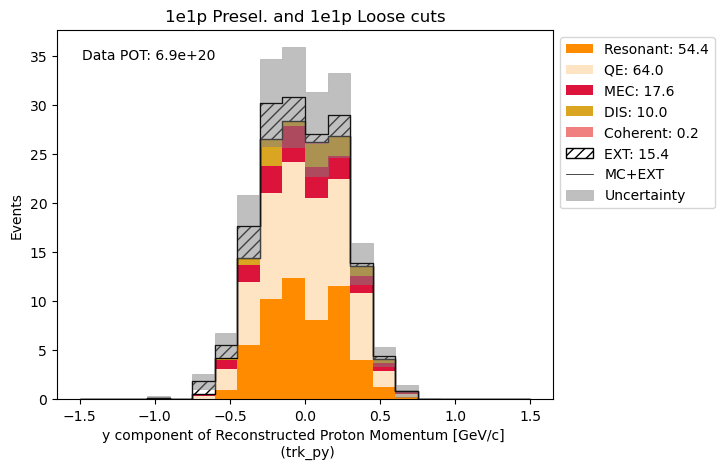

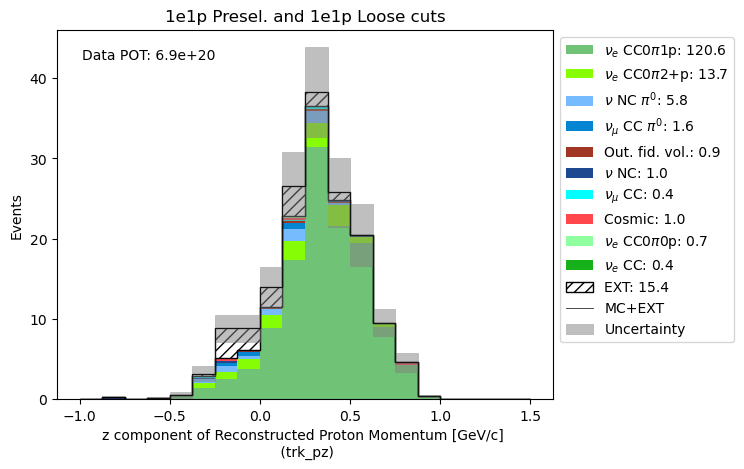

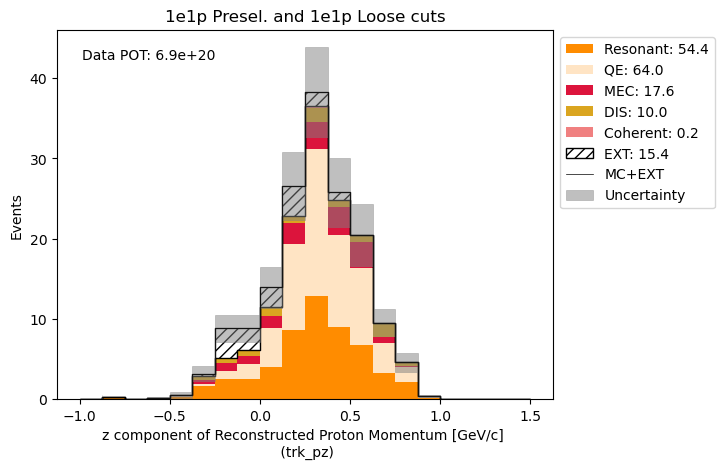

In [3]:
#selection = "NPL"
selection = "OnePL"
preselection = "OneP"

for binning_def in vdef.variables_1e1p:
    # some binning definitions have more than 4 elements,
    # we ignore the last ones for now
    binning = hist.Binning.from_config(*binning_def[:4])
    #binning = hist.Binning.from_config(*binning_def)
    signal_generator = hist.RunHistGenerator(
        rundata,
        binning,
        data_pot=data_pot,
        selection=selection,
        preselection=preselection,
        sideband_generator=None,
        uncertainty_defaults=None,
    )
    plotter = rp.RunHistPlotter(signal_generator)
    axes = plotter.plot(
        category_column="category_1e1p",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    plt.savefig('plots/microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    plt.show()
    
    axes2 = plotter.plot(
        category_column="interaction",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    plt.savefig('plots/microfit_int_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    plt.show()
    

In [5]:
# Calculating efficiency and purity

from microfit import selections as sel

selection = "OnePL"
preselection = "OneP"
query = f"{sel.preselection_categories[preselection]['query']} and {sel.selection_categories[selection]['query']}"
#print(query)

all_mc = pd.concat([df for k, df in rundata.items() if k!='data'])
all_predict = all_mc.query(query, engine='python')
#all_predict.head()

all_sig = all_mc['category_1e1p'] == 12
tot_all_sig = np.sum(all_mc.loc[all_sig, 'weights'])
print('Total candidate signal events:', tot_all_sig)

is_sig = all_predict['category_1e1p'] == 12
tot_sig = np.sum(all_predict.loc[is_sig, 'weights'])
tot_bkg = np.sum(all_predict.loc[~is_sig, 'weights'])
tot_evt = np.sum(all_predict['weights'])
print('After cuts:')
print('Total signal events:', tot_sig)
print('Total background events:', tot_bkg)
print('Total events:', tot_evt)
print('sig + bkg =', tot_sig+tot_bkg)

for binning_def in vdef.variables_1e1p:
#     lb = binning_def[2][0]
#     ub = binning_def[2][1]
#     print(lb, ub)
    
    x_plot = np.linspace(binning_def[2][0], binning_def[2][1], 100)
    eff = []
    pur = []
    bkg_eff = []
    
    for x in x_plot:
        sig_below = np.sum(all_predict.loc[is_sig & (all_predict[binning_def[0]] < x), 'weights'])
        bkg_below = np.sum(all_predict.loc[~is_sig & (all_predict[binning_def[0]] < x), 'weights'])
        
        eff.append(sig_below/tot_sig)
        pur.append(sig_below/(sig_below + bkg_below))
        bkg_eff.append(bkg_below/tot_bkg)
        
    
    fig1, ax1 = plt.subplots()
    ax1.plot(x_plot, pur, label='signal purity')
    ax1.plot(x_plot, eff, label='signal efficiency')
    ax1.plot(x_plot, bkg_eff, label='background efficiency')
    ax1.legend()
    ax1.set_xlabel(binning_def[3])
    #plt.ylabel('Signal Efficiency')
    ax1.set_title('1e1p Presel. and 1e1p Loose cuts')
    #plt.tight_layout()
    plt.savefig('plots/pur_eff_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
    plt.clf()
    
    fig2, ax2 = plt.subplots()
    ax2.plot(eff, pur)
    ax2.set_xlabel('Signal Efficiency')
    ax2.set_ylabel('Signal Purity')
    ax2.set_title('%s' %(binning_def[0]))
    #plt.tight_layout()
    plt.savefig('plots/eff_vs_pur_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
    plt.clf()
    
    plt.plot(eff, bkg_eff)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Acceptance efficiency')
    plt.title('%s' %(binning_def[0]))
    plt.tight_layout()
    plt.savefig('plots/roc_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
    plt.clf()

Total candidate signal events: 9059.503167984918
After cuts:
Total signal events: 120.58164011496757
Total background events: 40.932832351731456
Total events: 161.51447246669903
sig + bkg = 161.51447246669903


/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalar

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

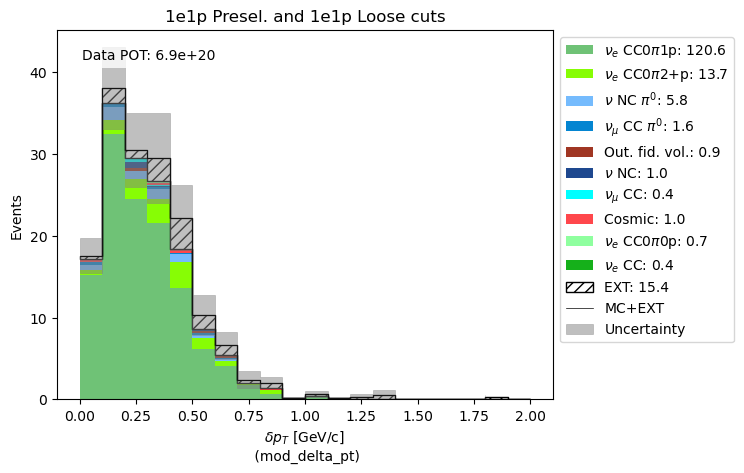

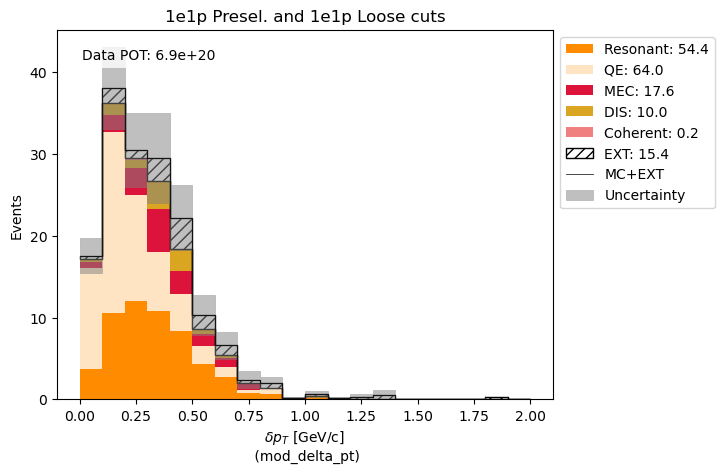

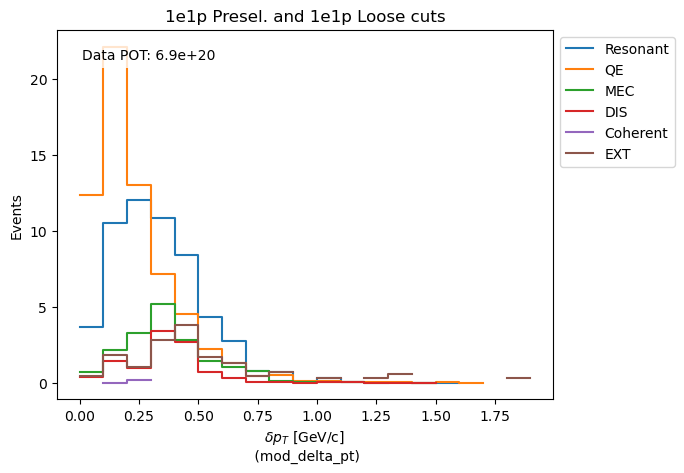

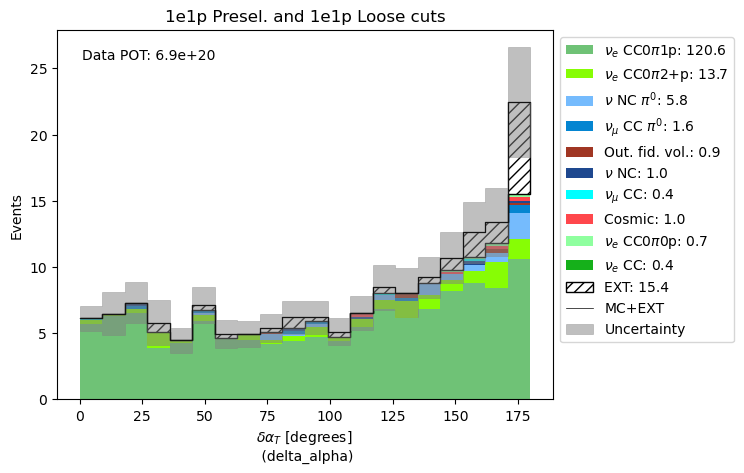

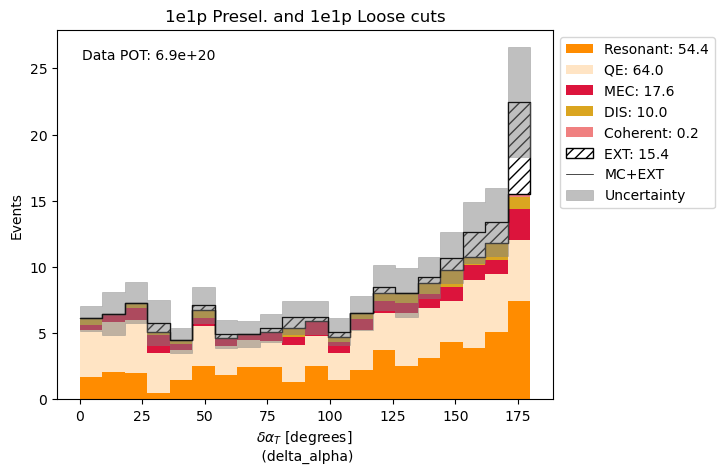

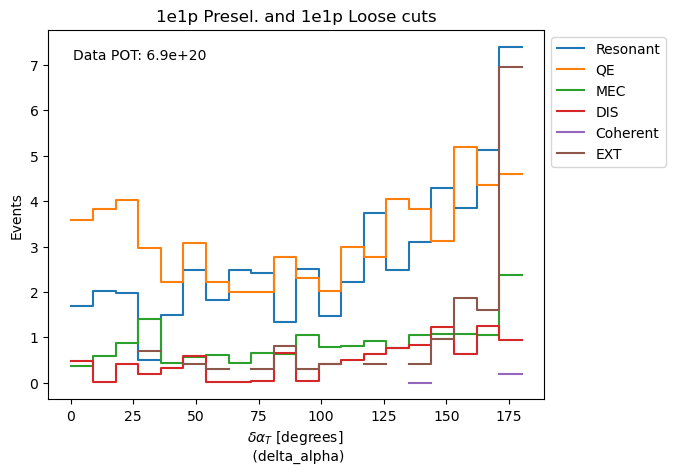

In [3]:
# Plotting TKI variables

selection = "OnePL"
preselection = "OneP"

for binning_def in vdef.TKI_variables_1e1p:
    # some binning definitions have more than 4 elements,
    # we ignore the last ones for now
    binning = hist.Binning.from_config(*binning_def[:4])
    #binning = hist.Binning.from_config(*binning_def)
    signal_generator = hist.RunHistGenerator(
        rundata,
        binning,
        data_pot=data_pot,
        selection=selection,
        preselection=preselection,
        sideband_generator=None,
        uncertainty_defaults=None,
    )
    plotter = rp.RunHistPlotter(signal_generator)
    axes = plotter.plot(
        category_column="category_1e1p",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    plt.savefig('plots/microfit_TKI_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    plt.show()
    
    axes2 = plotter.plot(
        category_column="interaction",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    plt.savefig('plots/microfit_TKI_int_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    plt.show()
    
    axes3 = plotter.plot(
        category_column="interaction",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
        stacked=False,
        show_total=False
    )
    #plt.savefig('plots/microfit_TKI_int_step_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    plt.show()

In [4]:
# Calculating efficiency and purity for TKI variables

from microfit import selections as sel

selection = "OnePL"
preselection = "OneP"
query = f"{sel.preselection_categories[preselection]['query']} and {sel.selection_categories[selection]['query']}"
#print(query)

all_predict = pd.concat([df for k, df in rundata.items() if k!='data']).query(query, engine='python')
#all_predict.head()

is_sig = all_predict['category_1e1p'] == 12
tot_sig = np.sum(all_predict.loc[is_sig, 'weights'])
tot_bkg = np.sum(all_predict.loc[~is_sig, 'weights'])
tot_evt = np.sum(all_predict['weights'])
print('Total signal events:', tot_sig)
print('Total background events:', tot_bkg)
print('Total events:', tot_evt)
print('sig + bkg =', tot_sig+tot_bkg)

for binning_def in vdef.TKI_variables_1e1p:
#     lb = binning_def[2][0]
#     ub = binning_def[2][1]
#     print(lb, ub)
    
    x_plot = np.linspace(binning_def[2][0], binning_def[2][1], 100)
    eff = []
    pur = []
    bkg_eff = []
    
    for x in x_plot:
        sig_below = np.sum(all_predict.loc[is_sig & (all_predict[binning_def[0]] < x), 'weights'])
        bkg_below = np.sum(all_predict.loc[~is_sig & (all_predict[binning_def[0]] < x), 'weights'])
        
        eff.append(sig_below/tot_sig)
        pur.append(sig_below/(sig_below + bkg_below))
        bkg_eff.append(bkg_below/tot_bkg)
        
    
    fig1, ax1 = plt.subplots()
    ax1.plot(x_plot, pur, label='signal purity')
    ax1.plot(x_plot, eff, label='signal efficiency')
    ax1.plot(x_plot, bkg_eff, label='background efficiency')
    ax1.legend()
    ax1.set_xlabel(binning_def[3])
    #plt.ylabel('Signal Efficiency')
    ax1.set_title('1e1p Presel. and 1e1p Loose cuts')
    #plt.tight_layout()
    plt.savefig('plots/pur_eff_TKI_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
    plt.clf()
    
    fig2, ax2 = plt.subplots()
    ax2.plot(eff, pur)
    ax2.set_xlabel('Signal Efficiency')
    ax2.set_ylabel('Signal Purity')
    ax2.set_title('%s' %(binning_def[0]))
    #plt.tight_layout()
    plt.savefig('plots/eff_vs_pur_TKI_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
    plt.clf()
    
    plt.plot(eff, bkg_eff)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Acceptance efficiency')
    plt.title('%s' %(binning_def[0]))
    plt.tight_layout()
    plt.savefig('plots/roc_TKI_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
    plt.clf()

Total signal events: 120.58164011496757
Total background events: 40.932832351731456
Total events: 161.51447246669903
sig + bkg = 161.51447246669903


/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>